# Experiments on Dai's Framework

In [45]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import itertools
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [46]:
def get_approaches_results(datasets, column_mean, column_std, group_by_th = False, items_num = 1000):
    mean = []
    std = []
    #initial
    if group_by_th == True:
        ths = datasets[0]["threshold"]
        for th in ths:
            for data in datasets:
                data = data[data["threshold"]==th]
                if(column_mean == 'cost'):
                    vals = data[column_mean]/data['cost_ratio'][0]/items_num
                    for v in vals:
                        mean.append(v)
                    vals_std = data[column_std]/data['cost_ratio'][0]/items_num
                    for s in vals_std:
                        std.append(s)
                else:
                    vals = data[column_mean]
                    for v in vals:
                        mean.append(v)
                    vals_std = data[column_std]
                    for s in vals_std:
                        std.append(s)
    else:
        for data in datasets:
            if(column_mean == 'cost'):
                vals = data[column_mean]/data['cost_ratio']/items_num
                for v in vals:
                    mean.append(v)
                vals_std = data[column_std]/data['cost_ratio']/items_num
                for s in vals_std:
                    std.append(s)
            else:
                vals = data[column_mean]
                for v in vals:
                    mean.append(v)
                vals_std = data[column_std]
                for s in vals_std:
                    std.append(s)
        
    return mean, std

def get_group_colors(groups, subgroups):
    #colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'white']
    return np.concatenate([[np.concatenate(np.random.rand(3,1))] * subgroups for x in range(groups)])

def concatenate(list1, list2):
    result = []
    for elem1 in list1:
        result.append(elem1)
        
    for elem2 in list2:
        result.append(elem2)
        
    return result

def get_total_results(list1, list2, column, mv_num=None, cost_ratio=None, decision_fn=None, threshold=None, class_fn=None, c=None, e=None):
    if mv_num != None:
        return concatenate(list1[list1['votes']==mv_num][column].values, 
                           list2[list2['votes']==mv_num][column].values)
    elif c != None:
        return concatenate(list1[list1['c']==c][list1['e']==e][column].values, 
                           list2[list2['c']==c][list2['e']==e][column].values)
    elif class_fn != None:
        return concatenate(list1[list1['class_fn']==class_fn][list1['decision_fn']==decision_fn][list1['cost_ratio']==cost_ratio][list1['threshold']==threshold][column].values, 
                           list2[list2['class_fn']==class_fn][list2['decision_fn']==decision_fn][list2['cost_ratio']==cost_ratio][list2['threshold']==threshold][column].values)
    elif decision_fn != None:
        return concatenate(list1[list1['decision_fn']==decision_fn][list1['cost_ratio']==cost_ratio][list1['threshold']==threshold][column].values, 
                           list2[list2['decision_fn']==decision_fn][list2['cost_ratio']==cost_ratio][list2['threshold']==threshold][column].values)
    else:
        return concatenate(list1[column].values, 
                           list2[column].values)

In [190]:
def plot_elems(elements, columns):
    #Figure 1
    ind = np.arange(len(elems))
    width = .1
    xticks_ind = ind + width / 2
    xticks_rotation = 70
    xticks_names = elems['name']
    
    plt.figure(num=1, figsize=(40, 20), dpi=80, facecolor='w', edgecolor='k')
    plt.subplots_adjust(bottom = .001)
    
    for key,column in enumerate(columns):
        plot_num = 331 + key
        plt.subplot(plot_num)
        column_mean = elements[column]
        column_std = elements[f"{column}_std"]

        p1 = plt.bar(ind, column_mean, width, yerr=column_std, zorder=3, color='red', edgecolor='black')
        plt.ylabel(column)
        plt.title(column, fontweight="bold")
        plt.xticks(xticks_ind, xticks_names, rotation=xticks_rotation)
        plt.grid(zorder=0)
        if max(elements[column]) > 1:
            plt.yticks(np.arange(0,max(elements[column])+3,1))
        else:
            plt.yticks(np.arange(0,1.1,.1))
        #plt.savefig("/Users/pmaglione/Repos/adaptive-pomdp-solutions/dai_pomdp/charts/test", bbox_inches = 'tight', pad_inches = 0)
        
        plt.plot(xticks_ind, column_mean, "k--")
        
    #end for
    plt.tight_layout()
    plt.show()

## Metrics: 
 - **Money spent(Cost), Loss, Precision and Recall, F1, Fbeta**
 - Loss Ratio = 5

## Experiments:

### 1. Try POMDP models with different rewards

POMDP definition: 
 - States: 23
 - Actions: 3 = {RequestVote, SubmitFalse, SubmitTrue}
 
 Transitions: 
 - $T(S_i, Action=RequestVote, S_i) = 1$
 - $T(S_i, Action=SubmitTrue, S_{terminal}) = 1$
 - $T(S_i, Action=SubmitFalse, S_{terminal}) = 1$
 
 Observations probabilities:
 - $O(S_i, RequestVote, CorrectAnswer) = Acc$
 - $O(S_i, RequestVote, IncorrectAnswer) = 1 - Acc$
 
 Worker Accuracy Formula:
 - $Acc(d, \gamma) = \frac{1}{2} (1 + (1 - d)^{\gamma}) $
 
 Rewards:
 - Request vote: -1
 - Correct answer: 0
 - Wrong answer: {-10, -500, -1000, -5000, -10000, -15000}

Workers:
 - Amount: 100
 - Error rate distribution: $\gamma \sim Normal(1, 0.2)$

         name  estimate_after    cost  recall  precision   loss     f1  fbeta
5    base-c10            True   1.000   0.741      0.751  0.770  0.746  0.741
6    base-c20            True   1.000   0.760      0.758  0.721  0.759  0.760
7    base-c50            True   2.950   0.892      0.893  0.324  0.892  0.892
8   base-c500            True   9.613   0.995      0.994  0.017  0.994  0.995
9  base-c1000            True  12.224   0.998      0.999  0.005  0.999  0.998


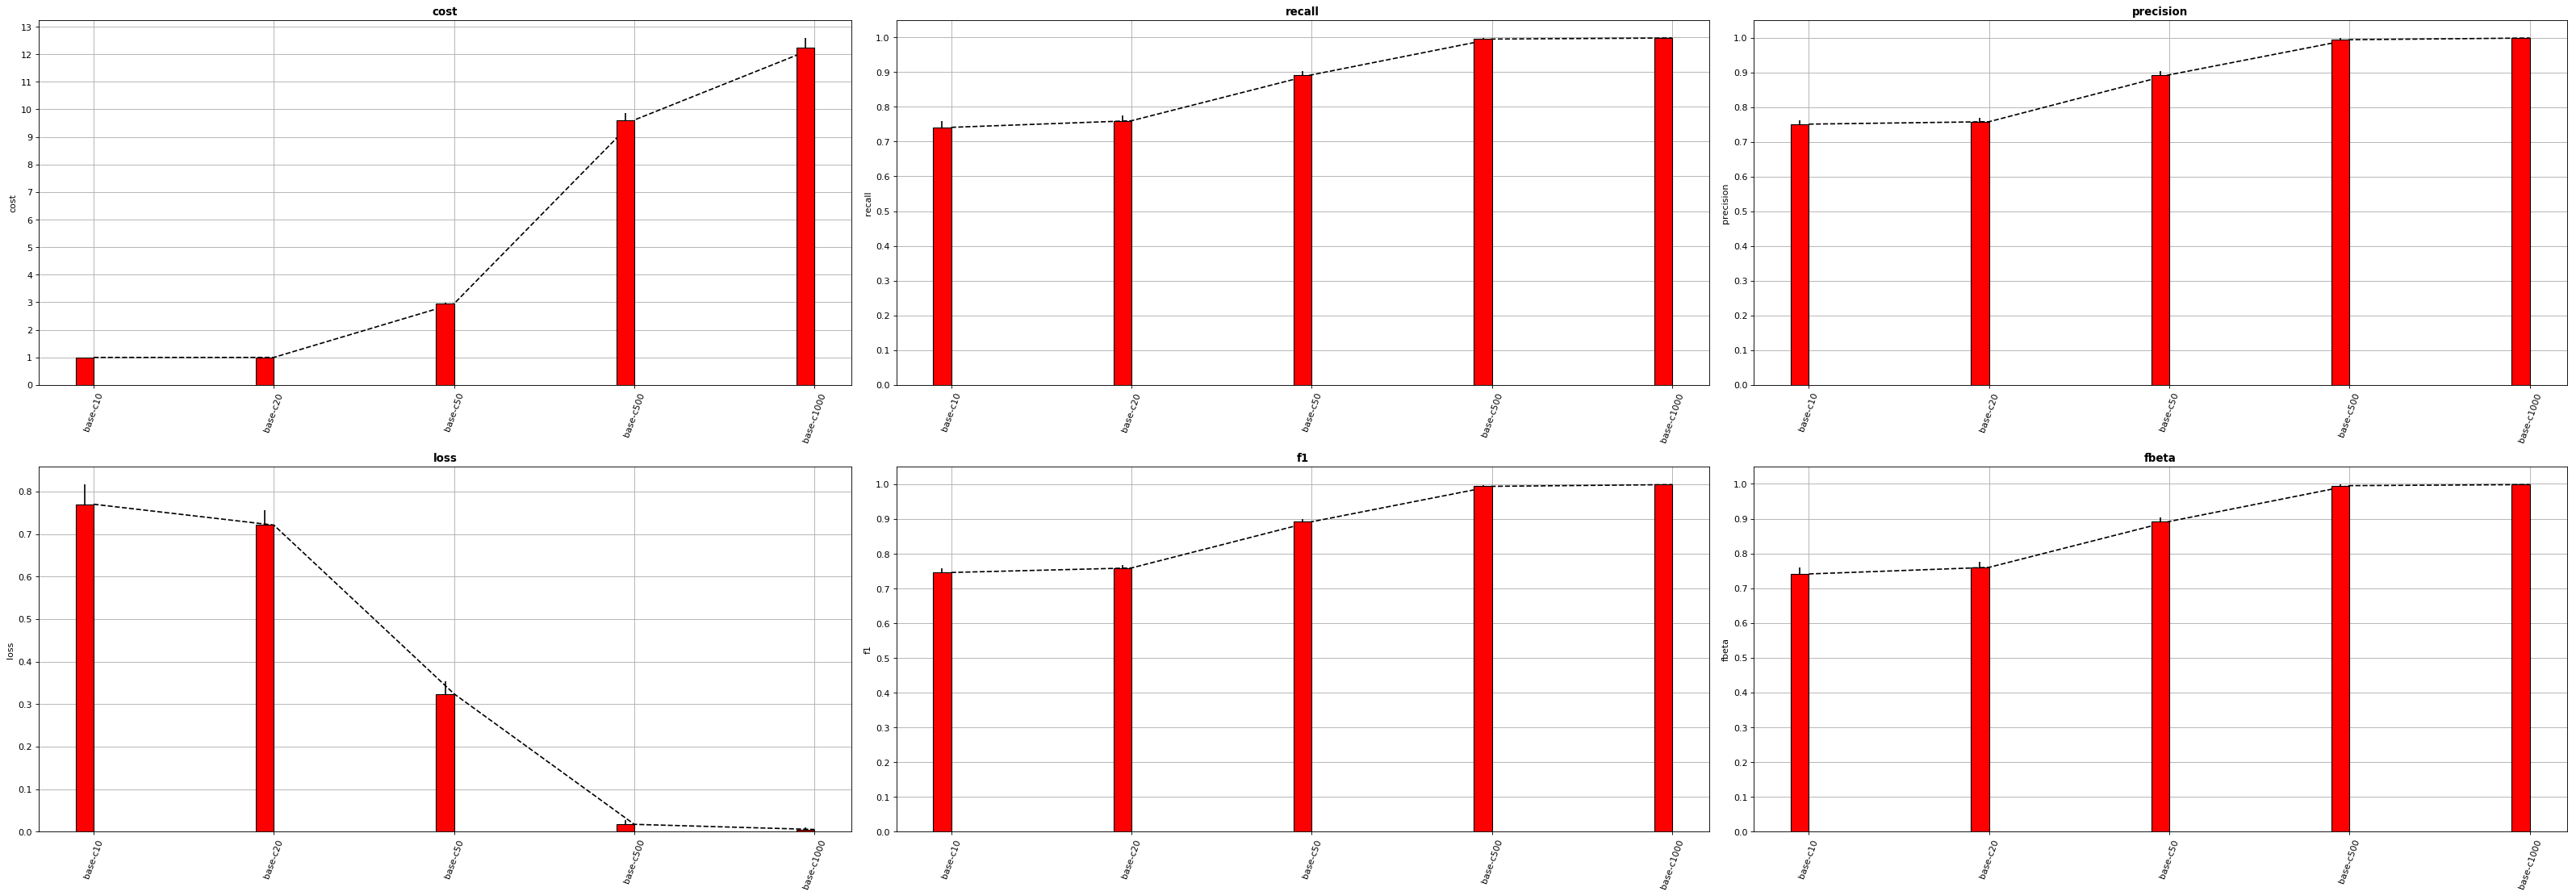

In [191]:
from IPython.core import display as ICD

data = pd.read_csv('/Users/pmaglione/Repos/adaptive-pomdp-solutions/dai_pomdp/results/pomdp_results.csv')
elems = data[data.name.str.startswith('base-')][data['estimate_after'] == True]

columns = ['cost', 'recall', 'precision', 'loss', 'f1', 'fbeta']

print(elems[['name', 'estimate_after']+columns])

plot_elems(elems, columns)

## 2. Test with different number of states in the model of MDP

POMDP definition: 
 - States #: {5,9,13,17}
     (difficulty, true_label)
    - 5:  (0,0)(1,0)(0,1)(1,1)(T)
    - 9:  (0,0)(0.33,0)(0.66,0)(1,0)(0,1)(0.33,1)(0.66,1)(1,1)(T)
    - 13: (0,0)(0.2,0)(0.4,0)(0.6,0)(0.8,0)(1,0)(0,1)(0.2,1)(0.4,1)(0.6,1)(0.8,1)(1,1)(T)
    - 17: (0,0)(0.15,0)(0.3,0)(0.45,0)(0.6,0)(0.75,0)(0.9,0)(1,0)(0,1)(0.15,1)(0.3,1)(0.45,1)(0.6,1)(0.75,1)(0.9,1)(1,1)(T)
    
    
 - Actions: 4 = {RequestVote, SubmitFalse, SubmitTrue}
 
 Transitions: 
 - $T(S_i, Action=RequestVote, S_i) = 1$
 - $T(S_i, Action=SubmitTrue, S_{terminal}) = 1$
 - $T(S_i, Action=SubmitFalse, S_{terminal}) = 1$
 
 Observations probabilities:
 - $O(S_i, RequestVote, CorrectAnswer) = Acc$
 - $O(S_i, RequestVote, IncorrectAnswer) = 1 - Acc$
 
 Worker Accuracy Formula:
 - $Acc(d, \gamma) = \frac{1}{2} (1 + (1 - d)^{\gamma}) $
 
 Rewards:
 - Request vote: -1
 - Correct answer: 0
 - Wrong answer: -500

Workers:
 - Amount: 100
 - Error rate distribution: $\gamma \sim Normal(1, 0.2)$


 
------------------------------------------------------------------------------------------
 
Num States: 5
 
    num_states  estimate_after  cost  recall  precision   loss     f1  fbeta
10           5           False   1.0   0.753      0.753  0.740  0.753  0.753
11           5           False   1.0   0.762      0.758  0.717  0.760  0.762
12           5           False   1.0   0.759      0.755  0.725  0.757  0.759
13           5           False   1.0   0.752      0.748  0.746  0.750  0.752
14           5           False   1.0   0.758      0.755  0.727  0.757  0.758
15           5            True   1.0   0.740      0.742  0.780  0.741  0.740
16           5            True   1.0   0.748      0.745  0.757  0.747  0.748
17           5            True   1.0   0.746      0.745  0.763  0.746  0.746
18           5            True   1.0   0.747      0.749  0.758  0.748  0.747
19           5            True   1.0   0.741      0.752  0.769  0.747  0.742


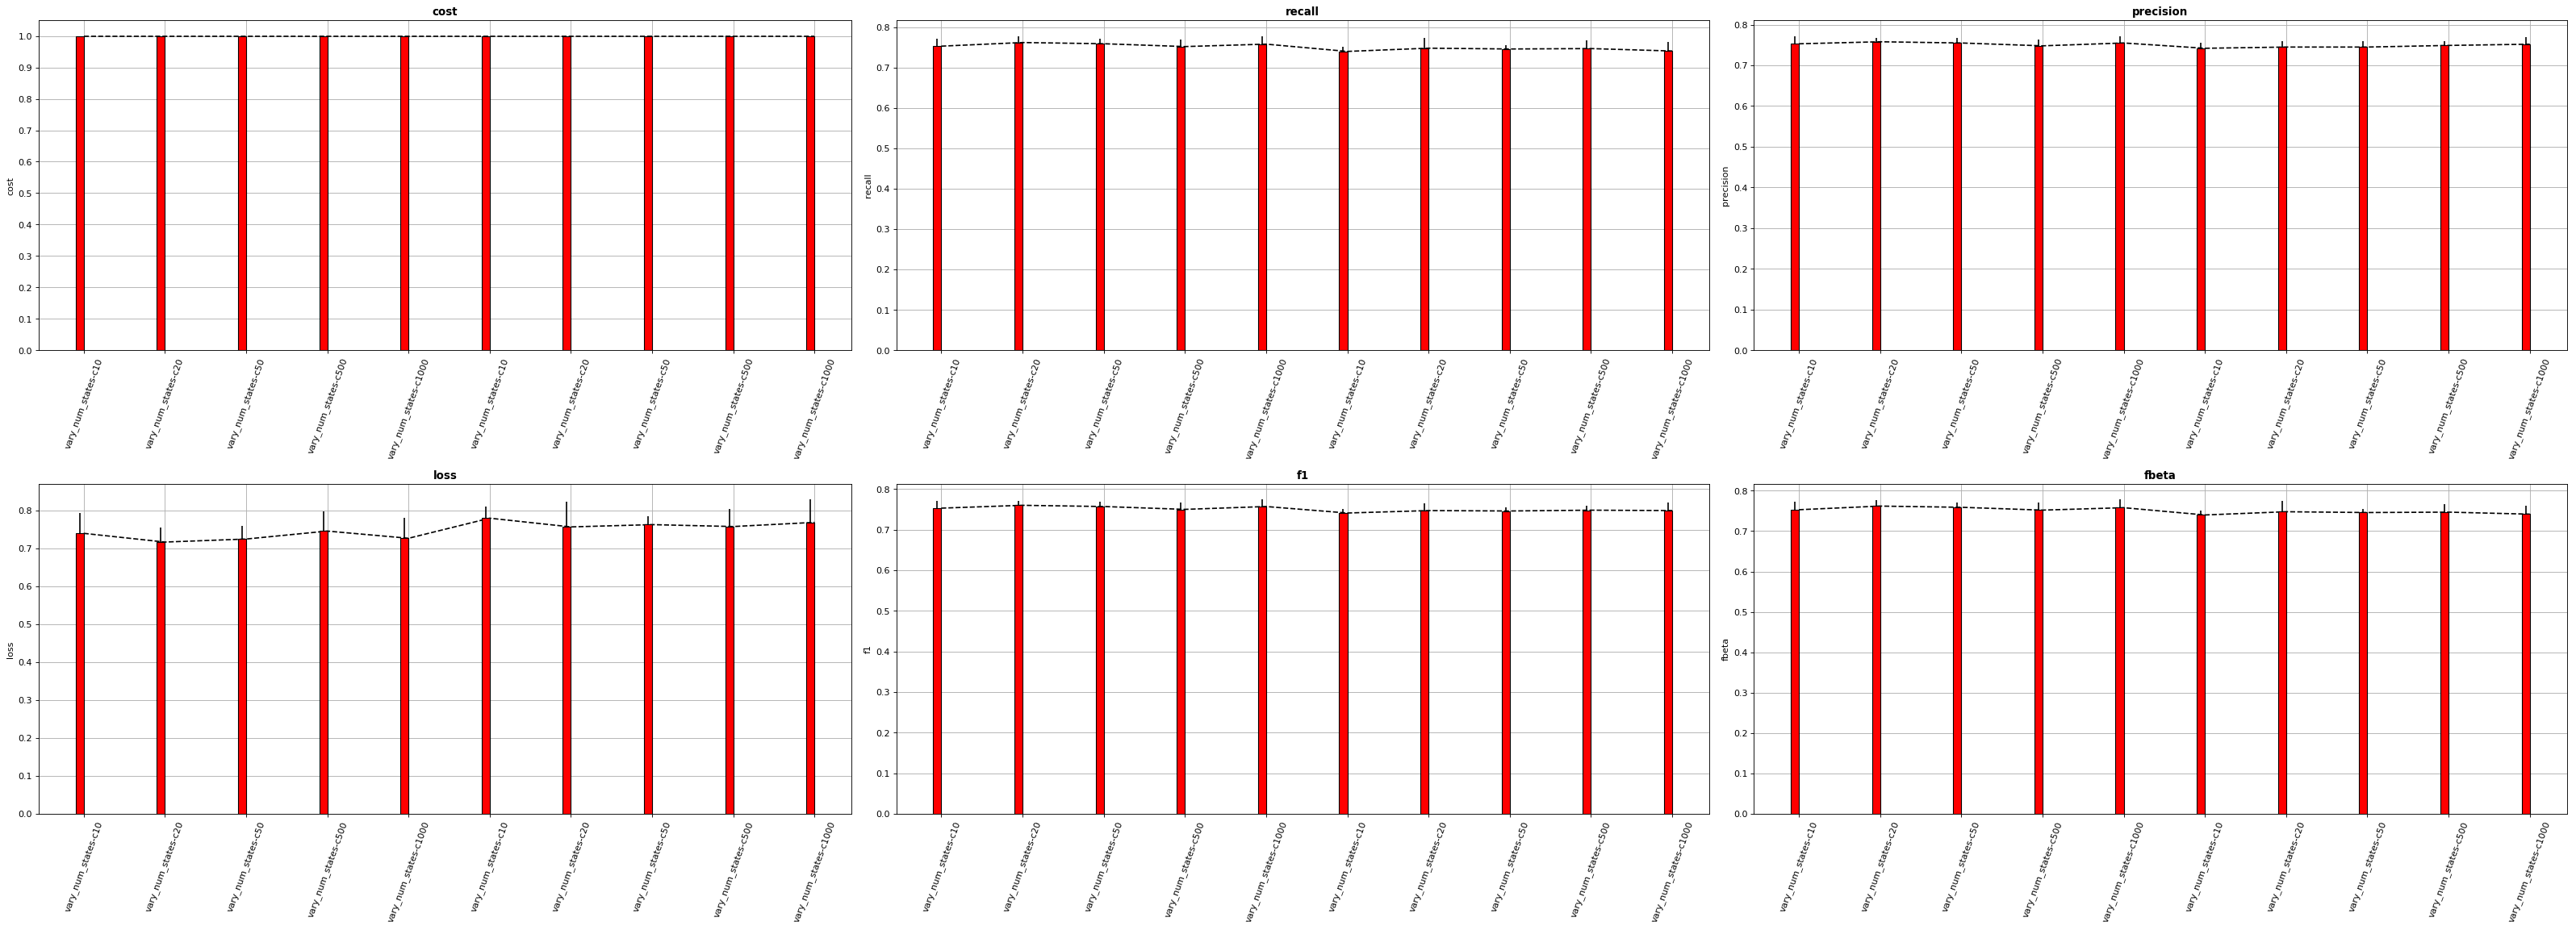

 
------------------------------------------------------------------------------------------
 
Num States: 9
 
    num_states  estimate_after   cost  recall  precision   loss     f1  fbeta
20           9           False  1.000   0.751      0.746  0.750  0.748  0.751
21           9           False  1.000   0.756      0.753  0.735  0.754  0.756
22           9           False  2.658   0.863      0.870  0.406  0.866  0.864
23           9           False  6.975   0.976      0.973  0.074  0.974  0.976
24           9           False  8.313   0.985      0.989  0.044  0.987  0.985
25           9            True  1.000   0.746      0.747  0.761  0.747  0.746
26           9            True  1.000   0.751      0.749  0.748  0.750  0.751
27           9            True  2.986   0.877      0.892  0.361  0.884  0.878
28           9            True  7.866   0.982      0.986  0.051  0.984  0.983
29           9            True  9.778   0.995      0.995  0.016  0.995  0.995


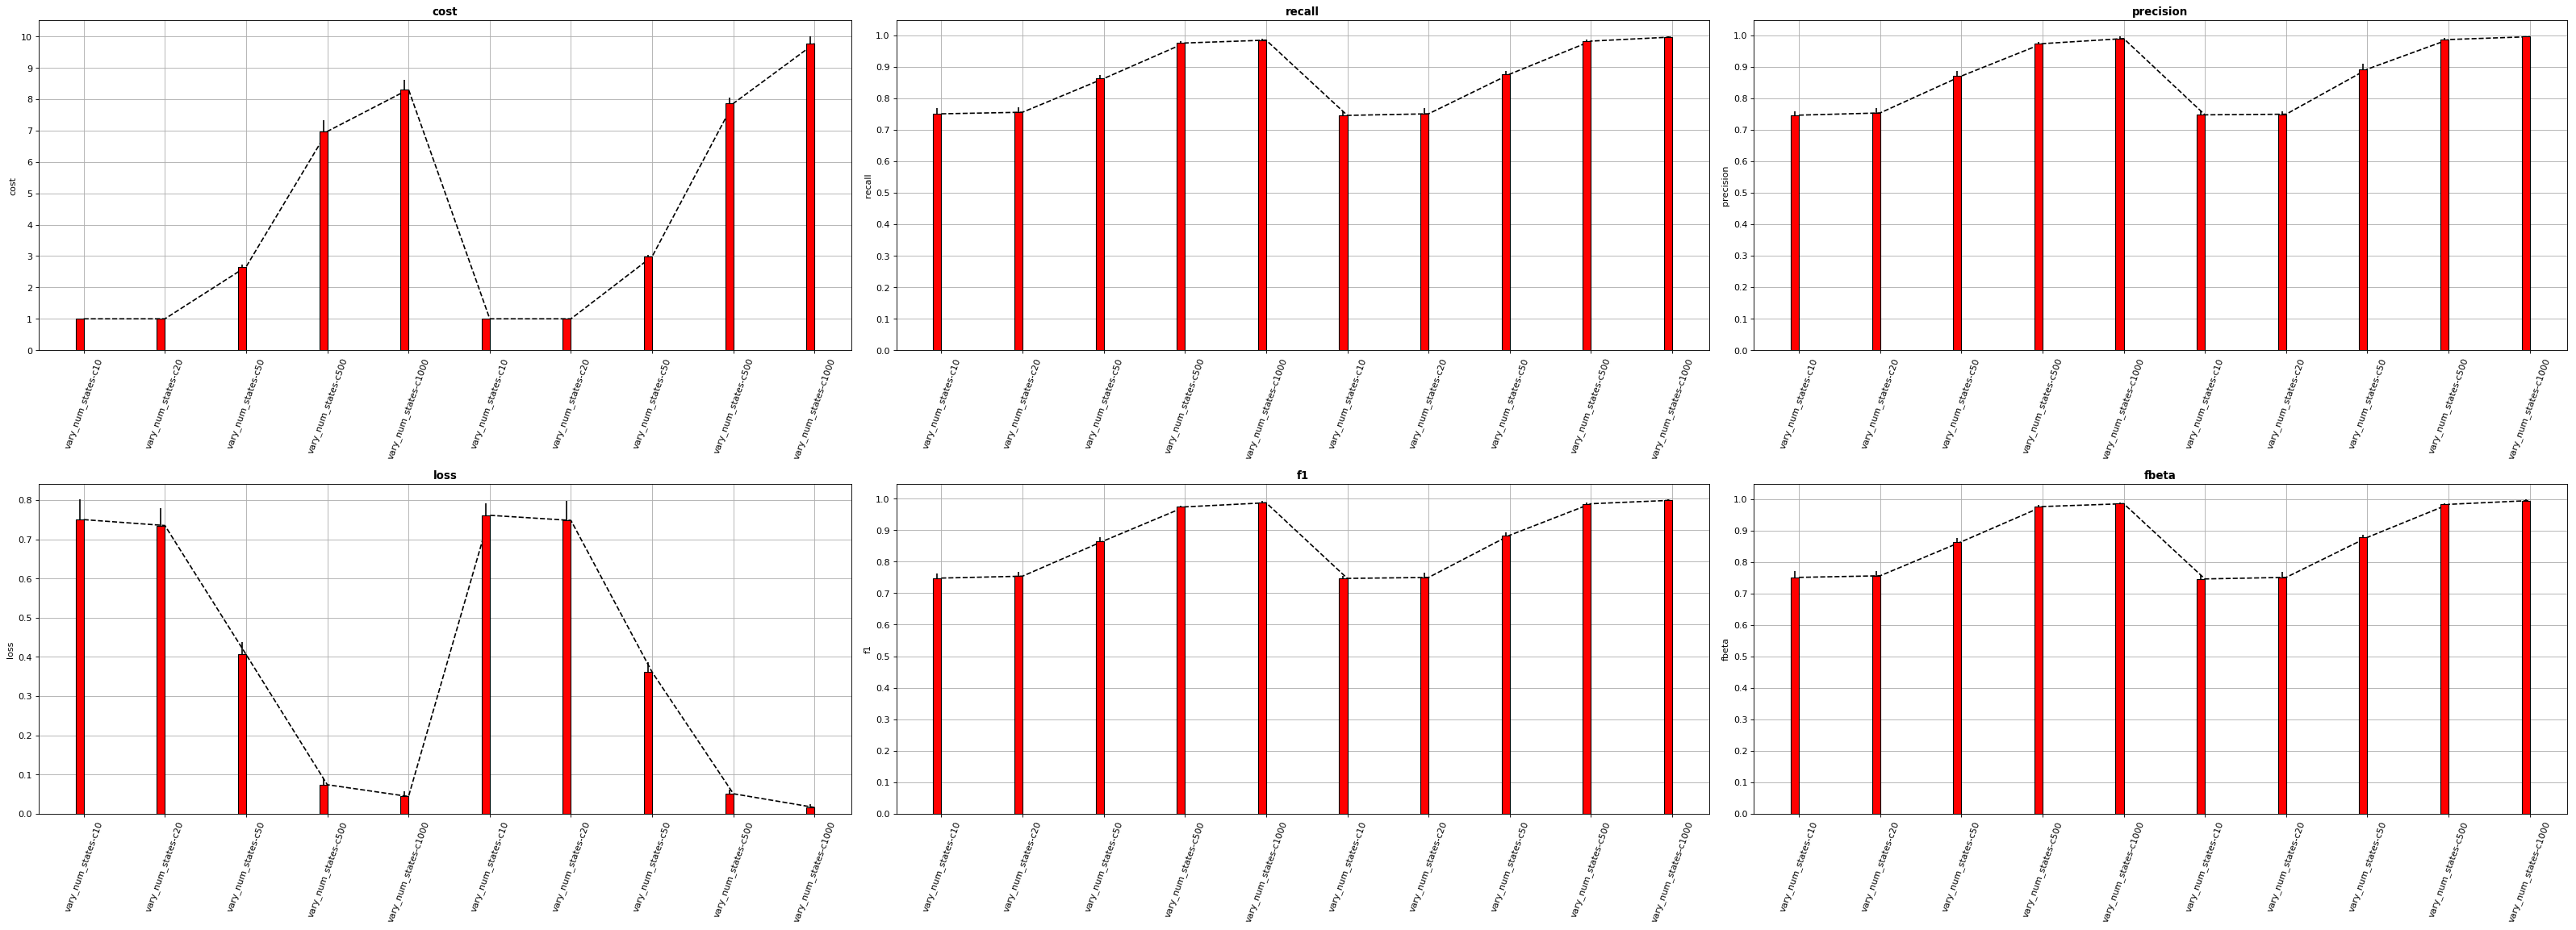

 
------------------------------------------------------------------------------------------
 
Num States: 13
 
    num_states  estimate_after    cost  recall  precision   loss     f1  fbeta
30          13           False   1.000   0.759      0.746  0.732  0.752  0.759
31          13           False   1.000   0.744      0.746  0.766  0.745  0.744
32          13           False   2.792   0.865      0.869  0.403  0.867  0.865
33          13           False   7.568   0.981      0.982  0.055  0.982  0.981
34          13           False   9.798   0.993      0.990  0.023  0.992  0.993
35          13            True   1.000   0.754      0.751  0.741  0.752  0.753
36          13            True   1.000   0.747      0.749  0.758  0.748  0.747
37          13            True   2.944   0.885      0.892  0.342  0.888  0.885
38          13            True   9.405   0.991      0.990  0.028  0.990  0.991
39          13            True  11.832   0.997      0.997  0.010  0.997  0.997


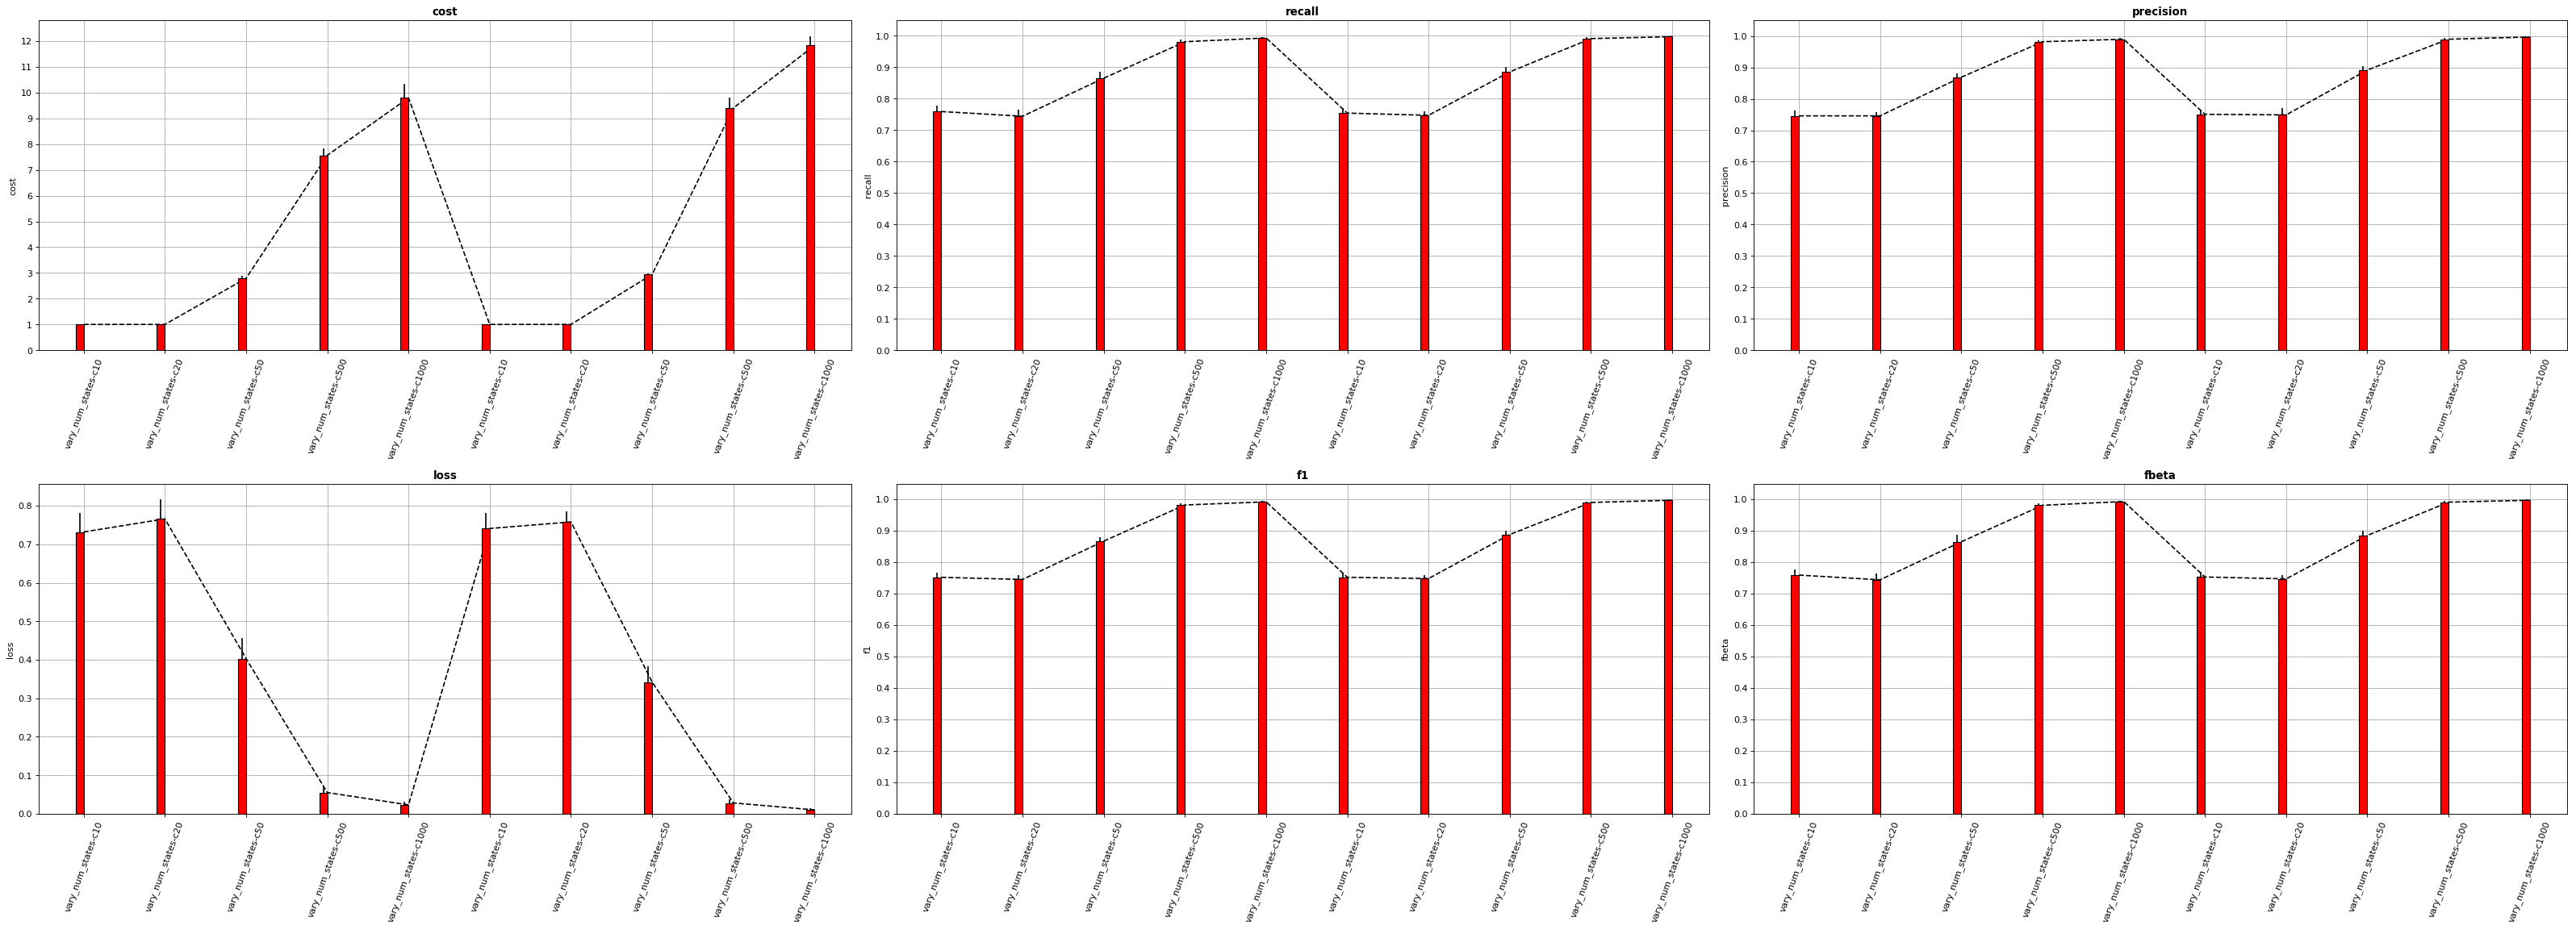

 
------------------------------------------------------------------------------------------
 
Num States: 17
 
    num_states  estimate_after    cost  recall  precision   loss     f1  fbeta
40          17           False   1.000   0.746      0.750  0.760  0.748  0.746
41          17           False   1.000   0.755      0.761  0.732  0.758  0.755
42          17           False   2.709   0.863      0.865  0.411  0.864  0.863
43          17           False   7.874   0.979      0.982  0.062  0.980  0.979
44          17           False   9.966   0.992      0.991  0.023  0.992  0.992
45          17            True   1.000   0.755      0.751  0.739  0.753  0.754
46          17            True   1.000   0.746      0.753  0.757  0.749  0.746
47          17            True   2.963   0.882      0.884  0.352  0.883  0.882
48          17            True   9.686   0.993      0.992  0.021  0.993  0.993
49          17            True  12.129   0.997      0.997  0.009  0.997  0.997


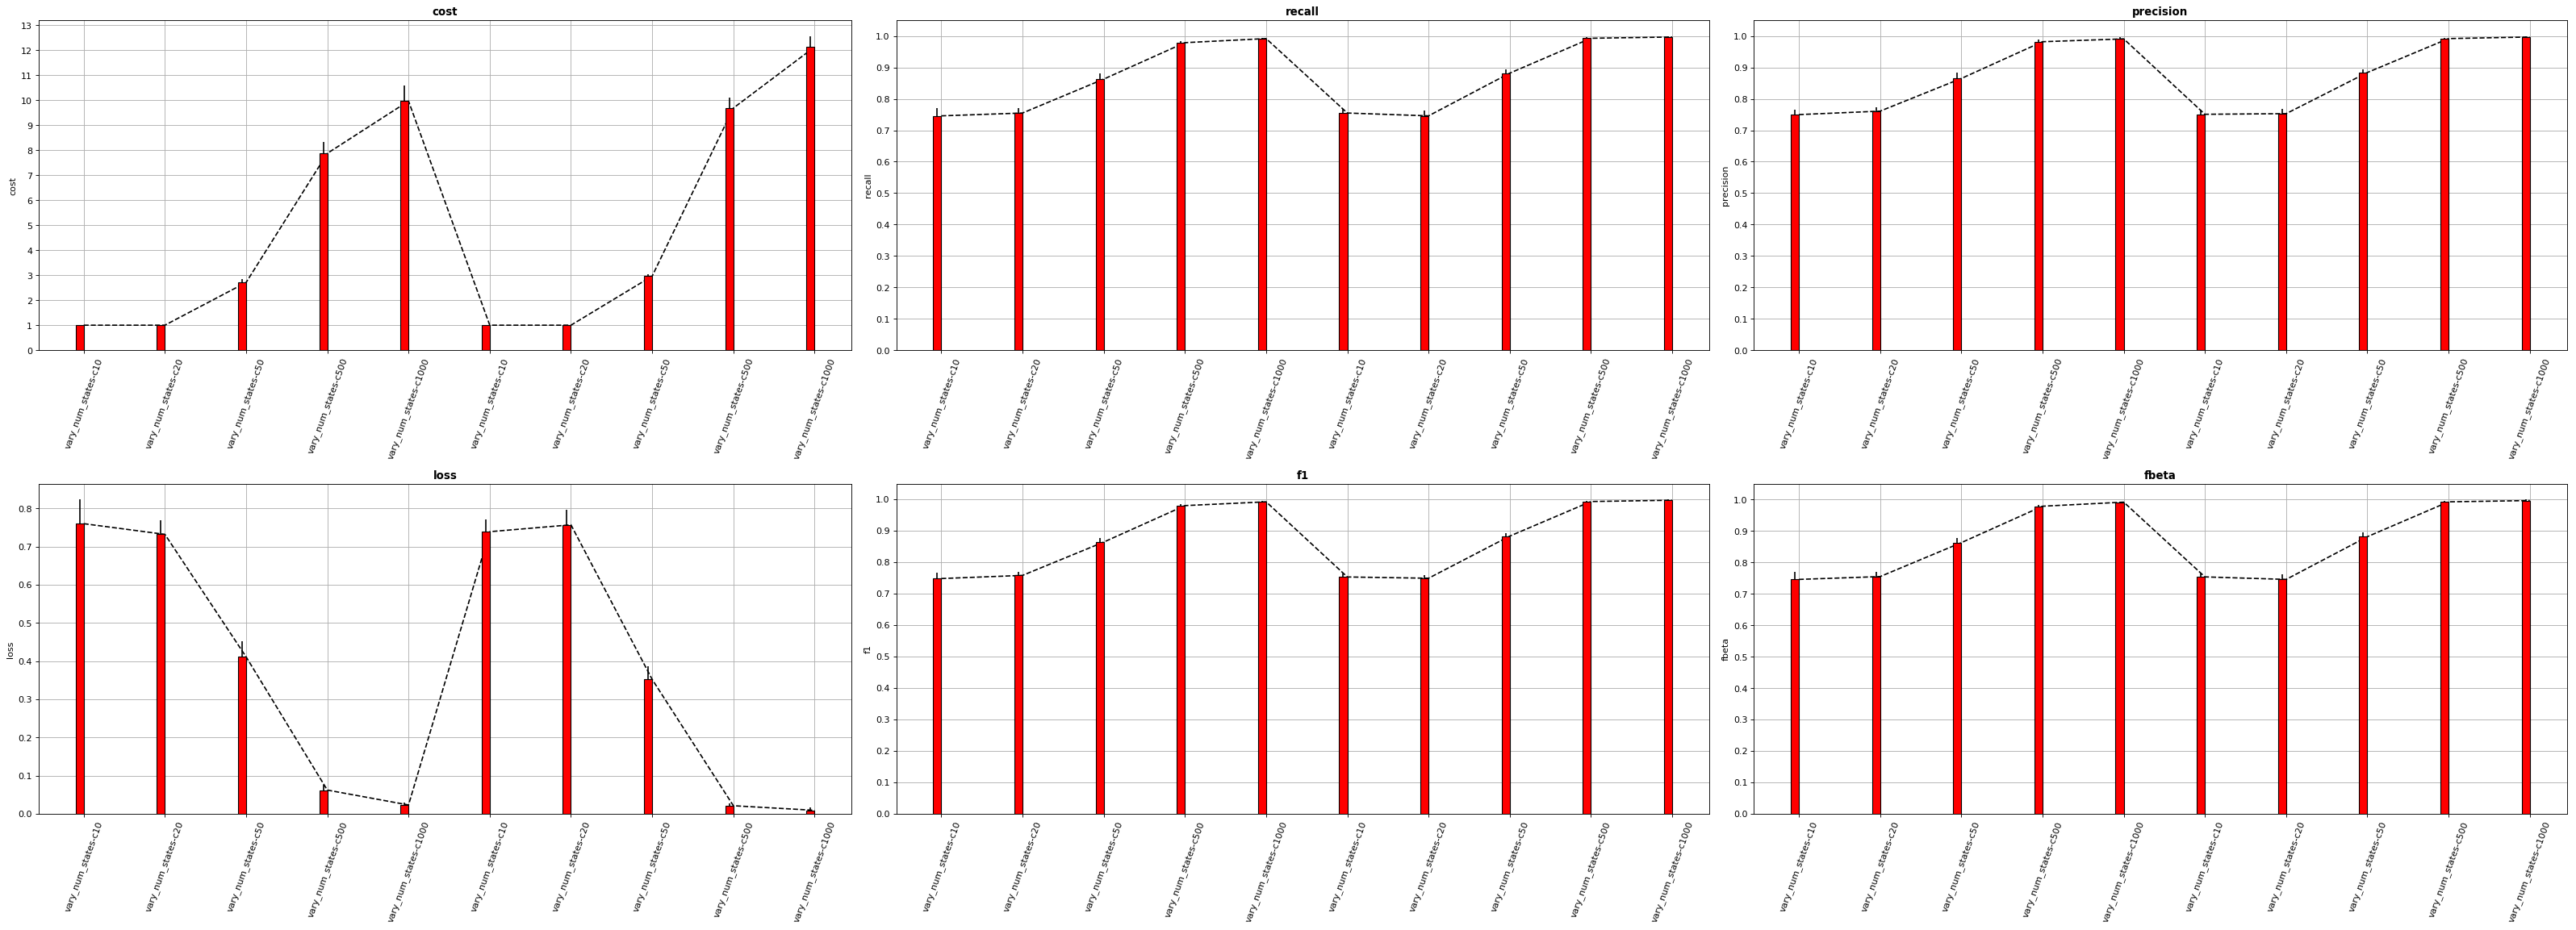

In [192]:
from IPython.core import display as ICD

data = pd.read_csv('/Users/pmaglione/Repos/adaptive-pomdp-solutions/dai_pomdp/results/pomdp_results.csv')

total_elems = data[data.name.str.startswith('vary_num_states')]

num_states = total_elems.num_states.unique()

for num_st in num_states:
    print(" ")
    print("------------------------------------------------------------------------------------------")
    print(" ")
    print(f"Num States: {num_st}")
    print(" ")
    
    elems = total_elems[total_elems.num_states == num_st]

    columns = ['cost', 'recall', 'precision', 'loss', 'f1', 'fbeta']

    print(elems[['num_states', 'estimate_after']+columns])

    plot_elems(elems, columns)
    
    

## 3. Try adding 1 the action of "leave item unclassified"

POMDP definition: 
 - States: 23
 - Actions: 4 = {RequestVote, SubmitFalse, SubmitTrue, LeaveUnclassified}
 
 Transitions: 
 - $T(S_i, Action=RequestVote, S_i) = 1$
 - $T(S_i, Action=SubmitTrue, S_{terminal}) = 1$
 - $T(S_i, Action=SubmitFalse, S_{terminal}) = 1$
 - $T(S_i, Action=LeaveUnclassified, S_{terminal}) = 1$
 
 Observations probabilities:
 - $O(S_i, RequestVote, CorrectAnswer) = Acc$
 - $O(S_i, RequestVote, IncorrectAnswer) = 1 - Acc$
 
 Worker Accuracy Formula:
 - $Acc(d, \gamma) = \frac{1}{2} (1 + (1 - d)^{\gamma}) $
 
 Rewards:
 - Request vote: -1
 - Correct answer: 0
 - Wrong answer: -500
 - Leave Unclassified: -5

Workers:
 - Amount: 100
 - Error rate distribution: $\gamma \sim Normal(1, 0.2)$


                     name  estimate_after    cost  recall  precision   loss  \
77      unclassify-c10-u5           False   1.000   0.558      0.562  1.322   
78     unclassify-c20-u10           False   1.000   0.558      0.563  1.321   
79     unclassify-c50-u20           False   2.864   0.616      0.601  1.165   
80   unclassify-c500-u200           False  10.561   0.686      0.696  0.936   
81  unclassify-c1000-u500           False  14.536   0.728      0.721  0.821   
82      unclassify-c10-u5            True   1.000   0.569      0.567  1.294   
83     unclassify-c20-u10            True   1.000   0.562      0.565  1.312   
84     unclassify-c50-u20            True   3.418   0.628      0.625  1.119   
85   unclassify-c500-u200            True  14.109   0.720      0.725  0.836   
86  unclassify-c1000-u500            True  19.292   0.752      0.756  0.742   

       f1  fbeta  
77  0.560  0.559  
78  0.561  0.558  
79  0.608  0.615  
80  0.691  0.686  
81  0.724  0.728  
82  0.568  0.569

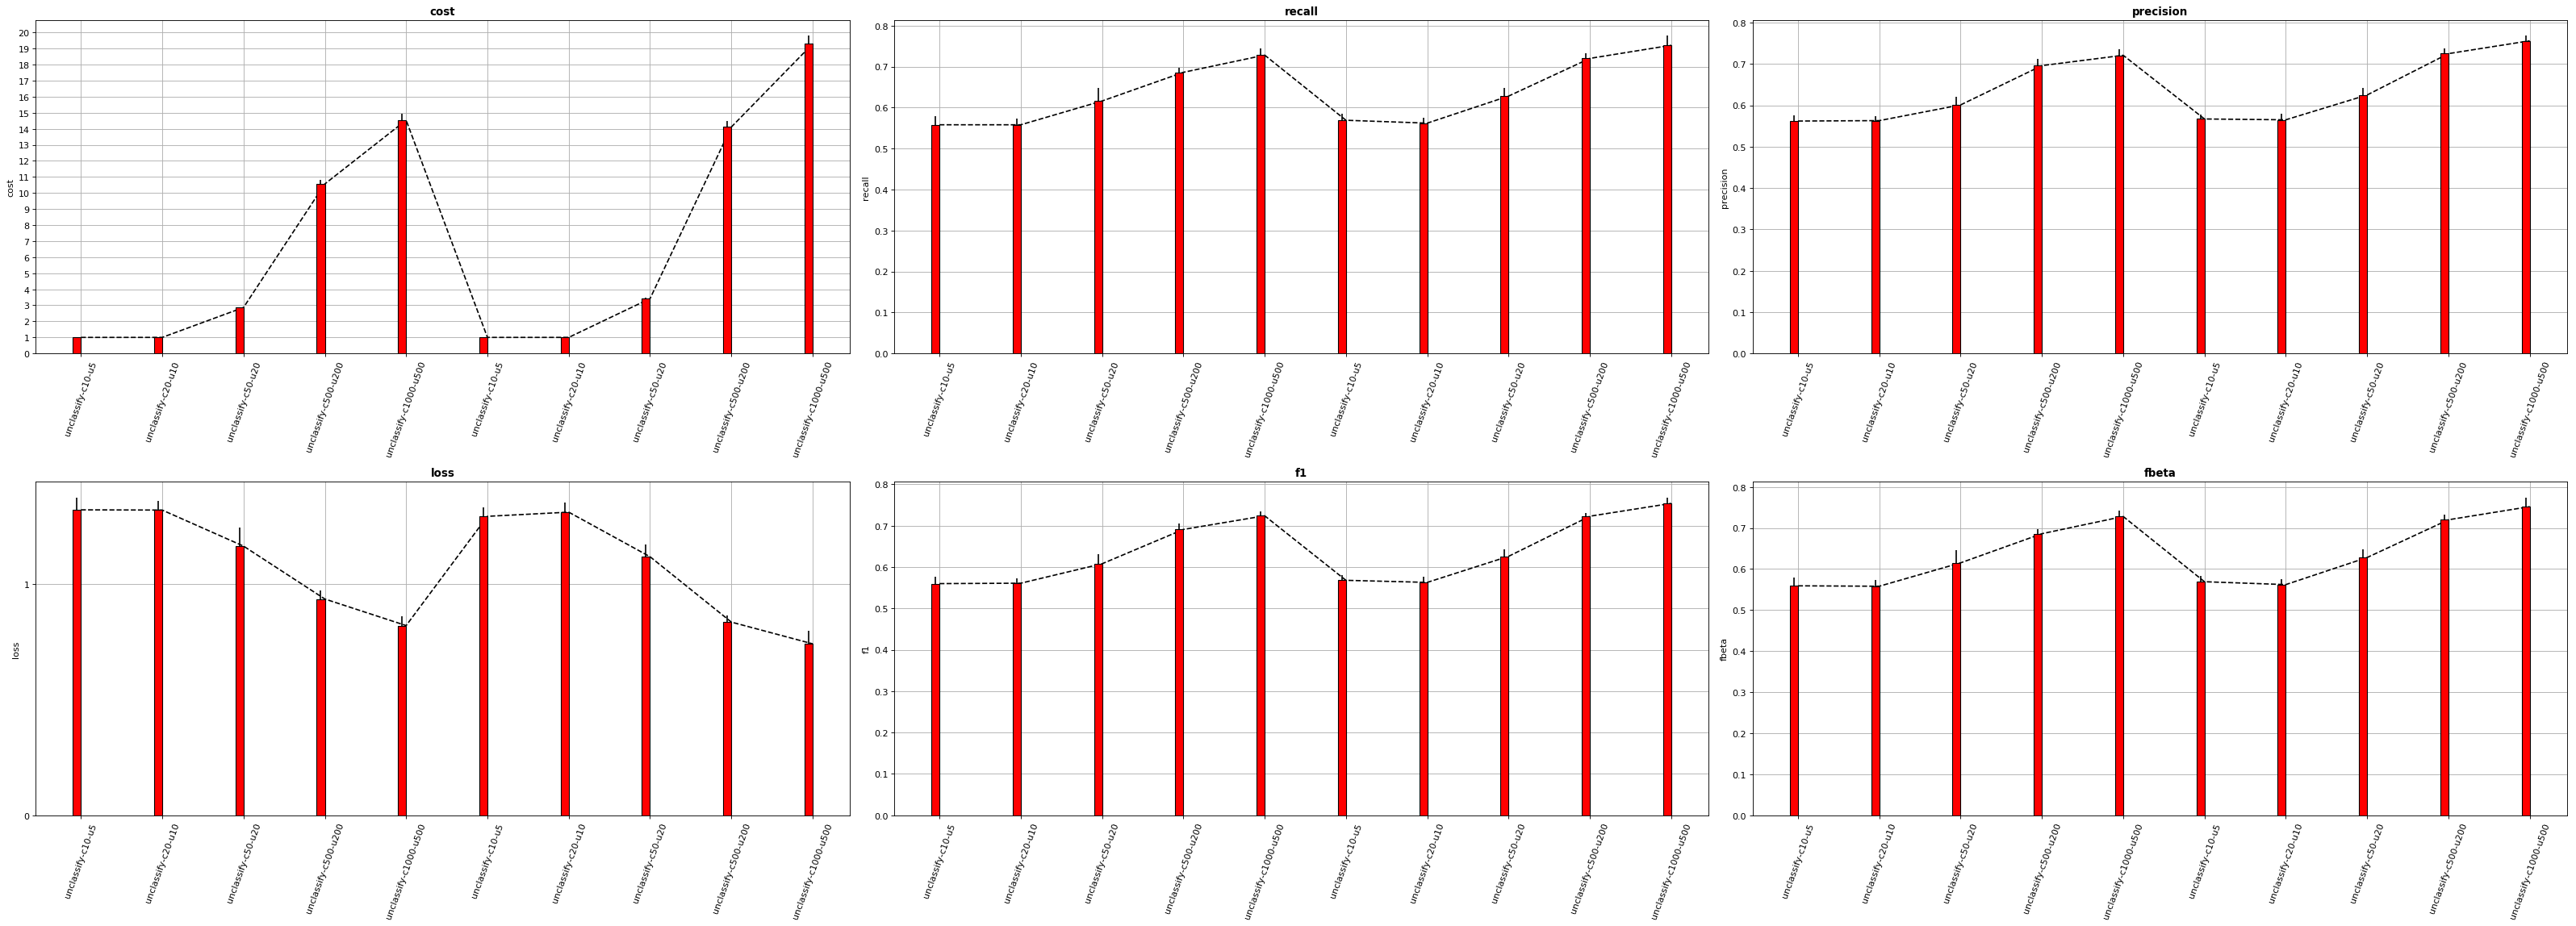

In [199]:
from IPython.core import display as ICD

data = pd.read_csv('/Users/pmaglione/Repos/adaptive-pomdp-solutions/dai_pomdp/results/pomdp_results.csv')
elems = data[data.name.str.startswith('unclassify-')]

columns = ['cost', 'recall', 'precision', 'loss', 'f1', 'fbeta']

print(elems[['name', 'estimate_after']+columns])

plot_elems(elems, columns)

## 4. Try with different error rate distribution

POMDP definition: 
 - States: 23
 
 Transitions: 
 - $T(S_i, Action=RequestVote, S_i) = 1$
 - $T(S_i, Action=SubmitTrue, S_{terminal}) = 1$
 - $T(S_i, Action=SubmitFalse, S_{terminal}) = 1$
 
 Observations probabilities:
 - $O(S_i, RequestVote, CorrectAnswer) = Acc$
 - $O(S_i, RequestVote, IncorrectAnswer) = 1 - Acc$
 
 Worker Accuracy Formula:
 - $Acc(d, \gamma) = \frac{1}{2} (1 + (1 - d)^{\gamma}) $
 
 Rewards:
 - Request vote: -1
 - Correct answer: 0
 - Wrong answer: {-10, -500, -1000, -5000, -10000, -15000}

Workers:
 - Amount: 100

### 4.1 Worker error rate distribution: Bimodal
 - 50%: $\gamma \sim Normal(1, 0.2)$
 - 50%: $\gamma \sim Normal(4, 0.2)$ 

             name   cost  recall  precision   loss     f1  fbeta
50    bimodal-c10  1.000   0.738      0.738  0.787  0.738  0.738
51    bimodal-c20  1.000   0.746      0.733  0.770  0.740  0.746
52    bimodal-c50  2.687   0.873      0.878  0.378  0.875  0.873
53   bimodal-c500  5.858   0.985      0.985  0.045  0.985  0.985
54  bimodal-c1000  6.668   0.993      0.992  0.022  0.992  0.993
55    bimodal-c10  1.000   0.737      0.736  0.791  0.736  0.737
56    bimodal-c20  1.000   0.730      0.728  0.811  0.729  0.730
57    bimodal-c50  3.043   0.889      0.892  0.332  0.890  0.889
58   bimodal-c500  8.294   0.991      0.992  0.026  0.992  0.991
59  bimodal-c1000  9.799   0.996      0.993  0.013  0.995  0.996


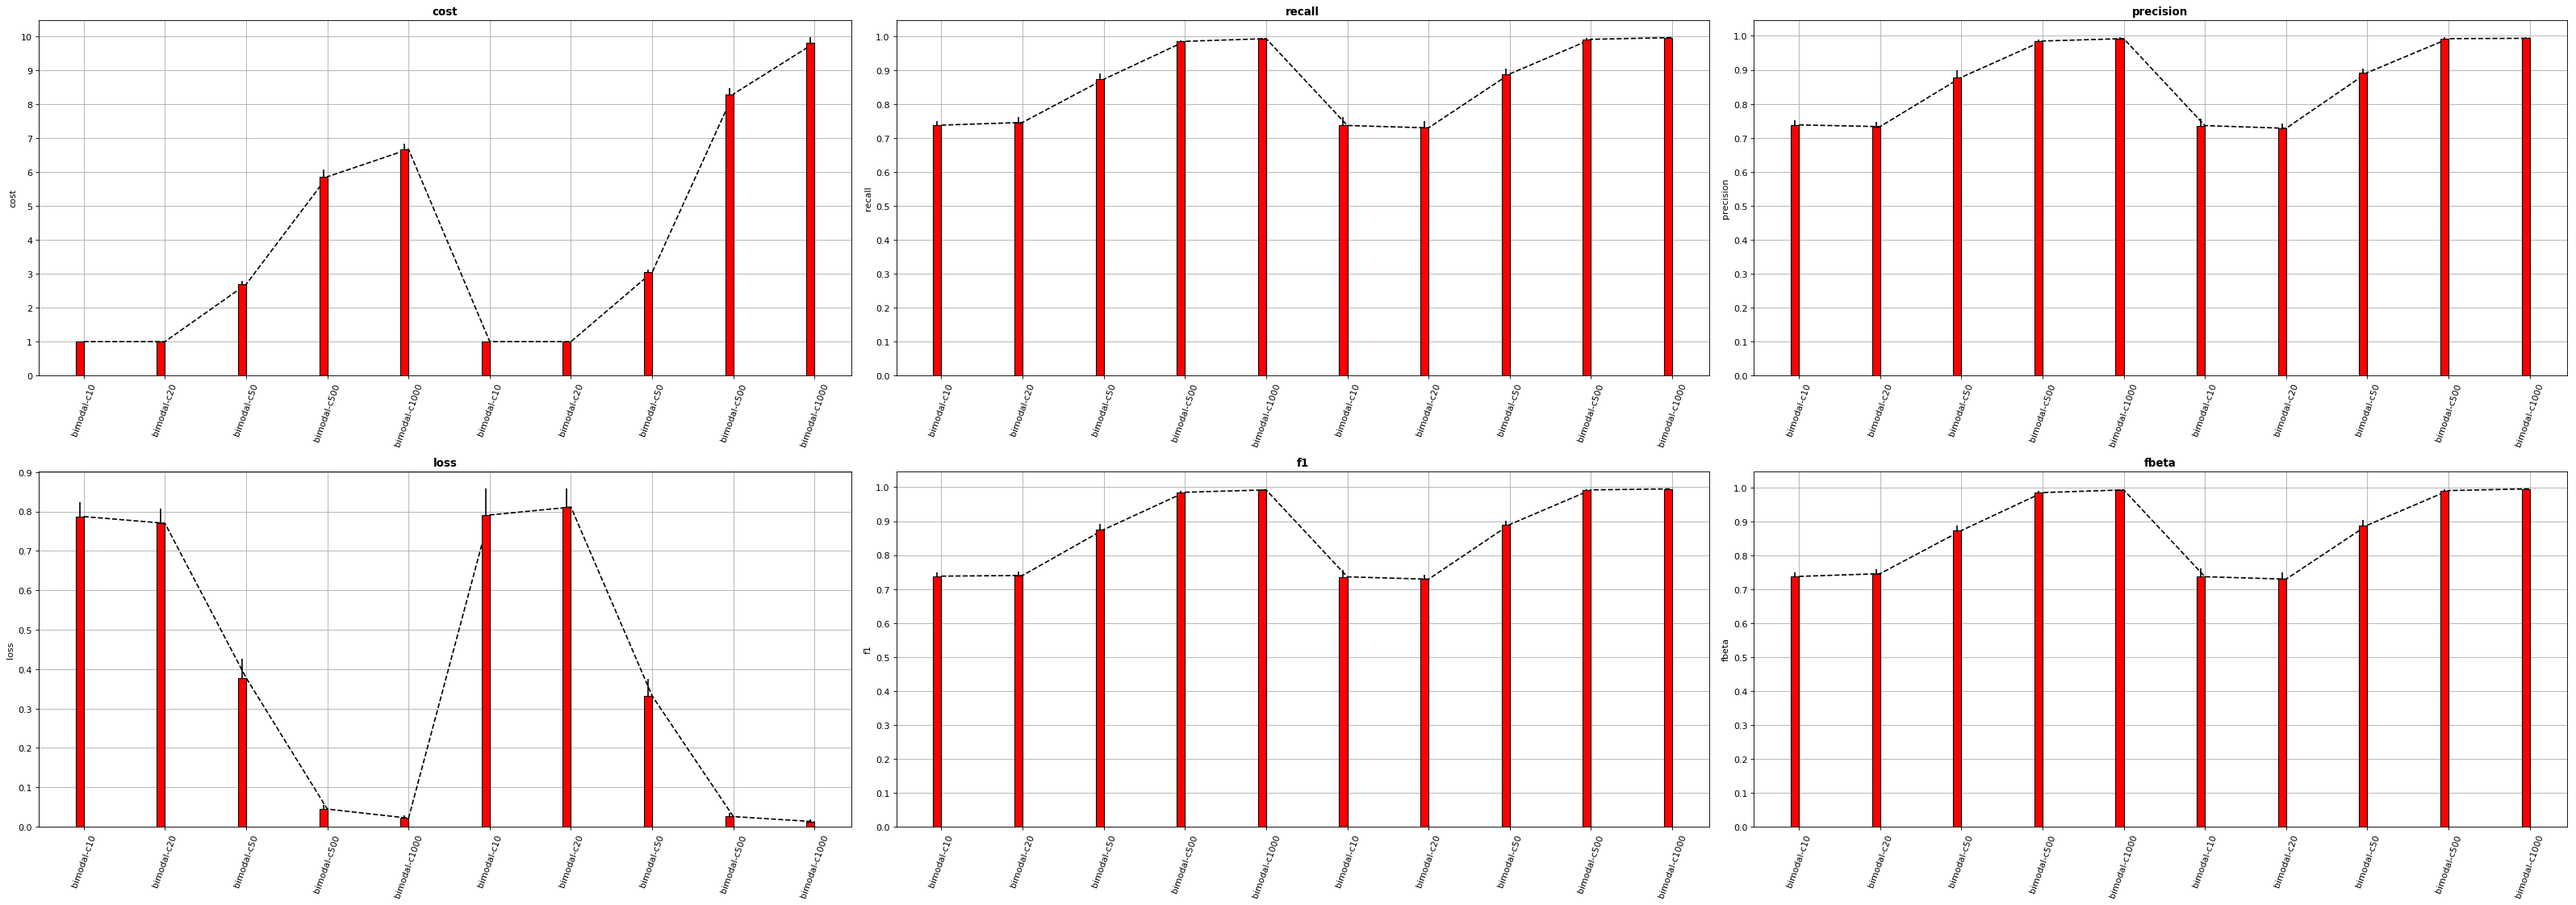

In [194]:
from IPython.core import display as ICD

data = pd.read_csv('/Users/pmaglione/Repos/adaptive-pomdp-solutions/dai_pomdp/results/pomdp_results.csv')
elems = data[data.name.str.startswith('bimodal')]

columns = ['cost', 'recall', 'precision', 'loss', 'f1', 'fbeta']

print(elems[['name']+columns])

plot_elems(elems, columns)

### 4.2 Worker error rate distribution (good workers - low error): $\gamma \sim Normal(1, 0.2)$ 

- 100%: $\gamma \sim Normal(0.2, 0.01)$

          name  estimate_after   cost  recall  precision   loss     f1  fbeta
60    good-c10           False  1.000   0.935      0.931  0.197  0.933  0.935
61    good-c20           False  1.000   0.935      0.937  0.195  0.936  0.935
62    good-c50           False  2.121   0.979      0.985  0.060  0.982  0.979
63   good-c500           False  3.102   0.999      0.997  0.003  0.998  0.999
64  good-c1000           False  3.680   0.999      0.999  0.004  0.999  0.999
65    good-c10            True  1.000   0.939      0.937  0.185  0.938  0.939
66    good-c20            True  1.000   0.940      0.939  0.180  0.940  0.940
67    good-c50            True  2.243   0.993      0.992  0.021  0.993  0.993
68   good-c500            True  5.641   1.000      1.000  0.001  1.000  1.000
69  good-c1000            True  6.773   1.000      1.000  0.000  1.000  1.000


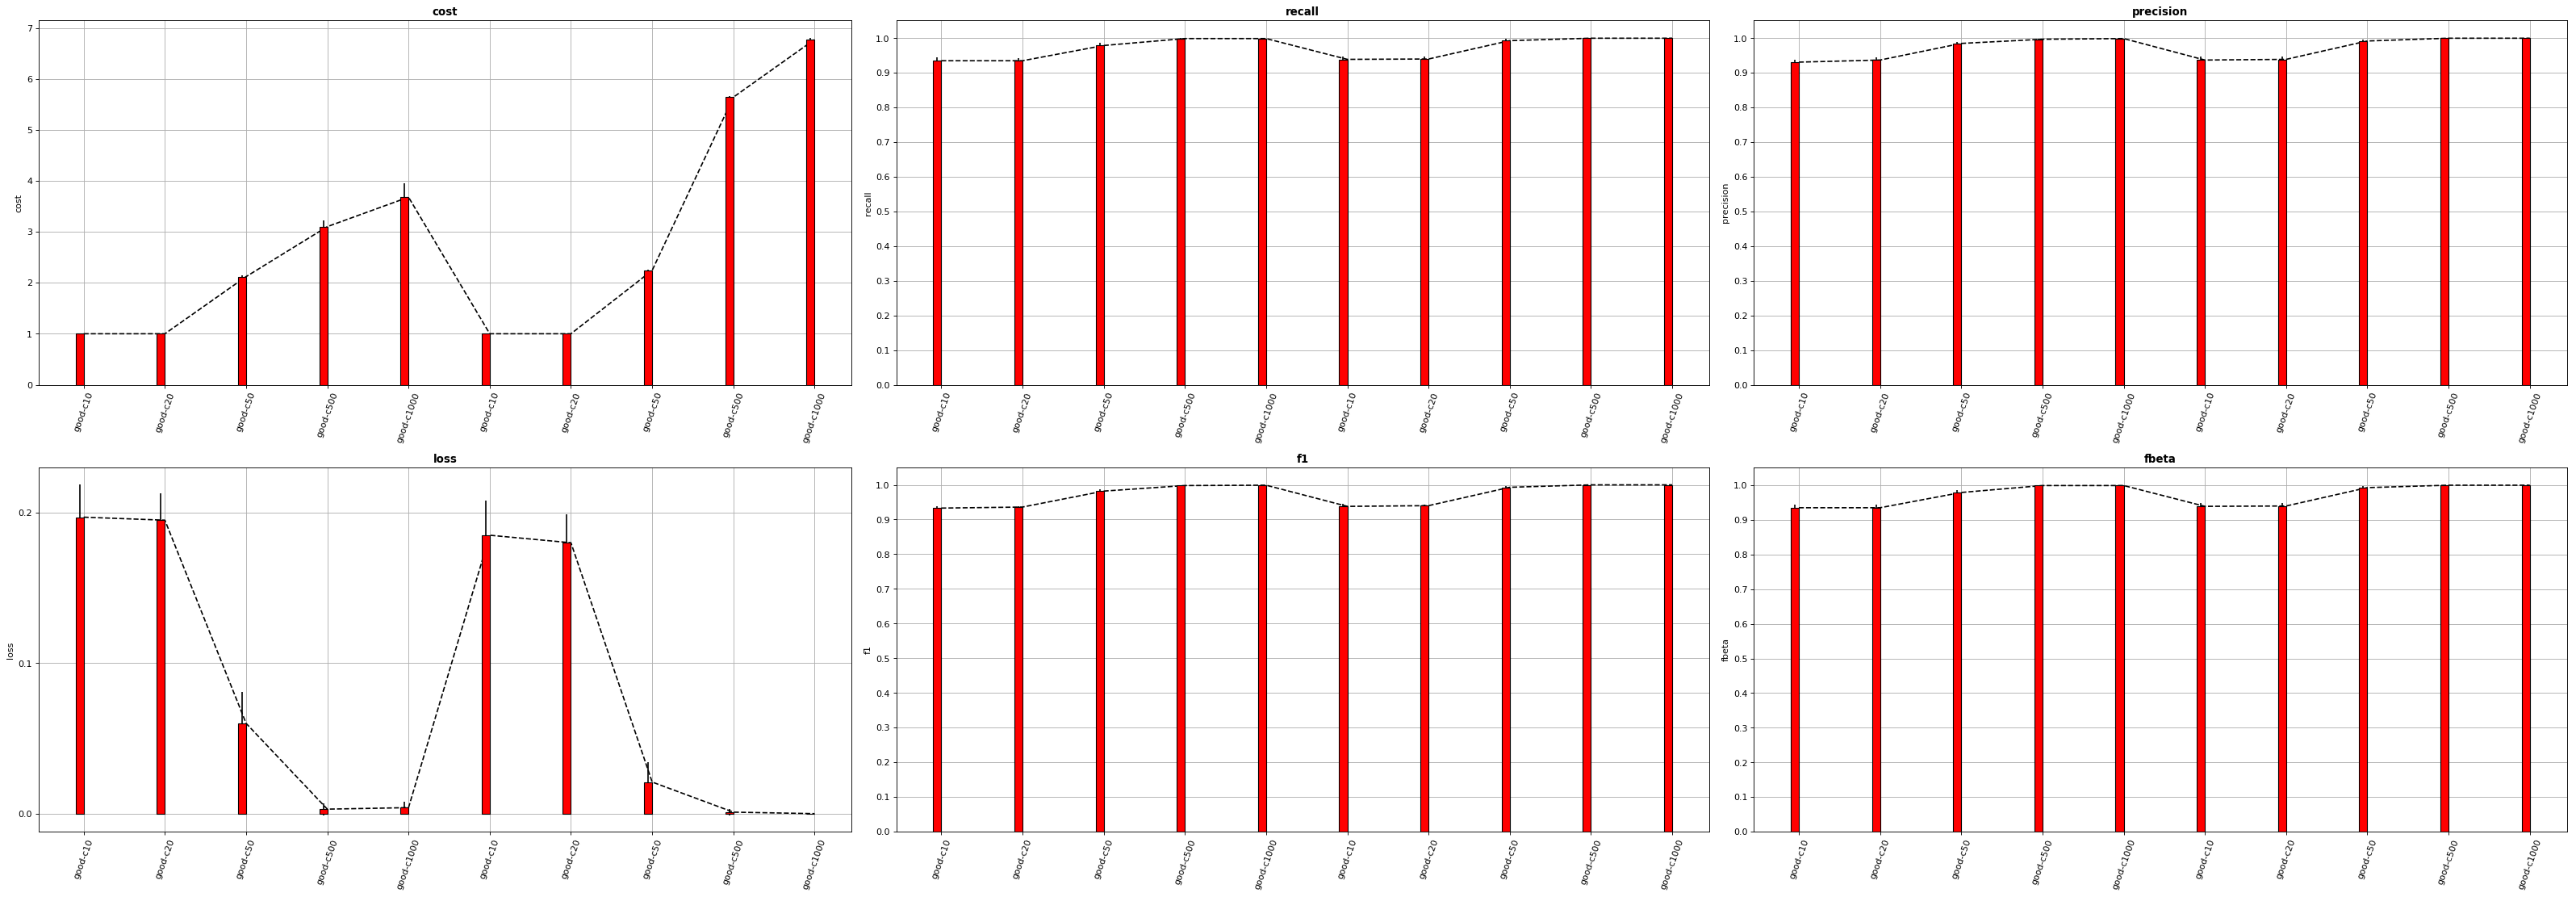

In [195]:
from IPython.core import display as ICD

data = pd.read_csv('/Users/pmaglione/Repos/adaptive-pomdp-solutions/dai_pomdp/results/pomdp_results.csv')
elems = data[data.name.str.startswith('good')]

columns = ['cost', 'recall', 'precision', 'loss', 'f1', 'fbeta']

print(elems[['name', 'estimate_after']+columns])

plot_elems(elems, columns)

### 4.3 Worker error rate distribution (bad workers - high error):  $\gamma \sim Normal(4, 0.2)$ 
- 100%: $\gamma \sim Normal(4, 0.2)$

         name  estimate_after    cost  recall  precision   loss     f1  fbeta
70    bad-c10           False   1.000   0.573      0.567  1.285  0.570  0.573
71    bad-c20           False   1.000   0.559      0.564  1.318  0.561  0.560
72    bad-c50           False   3.311   0.602      0.598  1.197  0.600  0.602
73   bad-c500           False  10.872   0.686      0.695  0.936  0.690  0.686
74  bad-c1000           False  14.876   0.726      0.726  0.821  0.726  0.726
75   bad-c500            True  14.250   0.709      0.716  0.869  0.712  0.709
76  bad-c1000            True  20.005   0.748      0.749  0.756  0.748  0.748


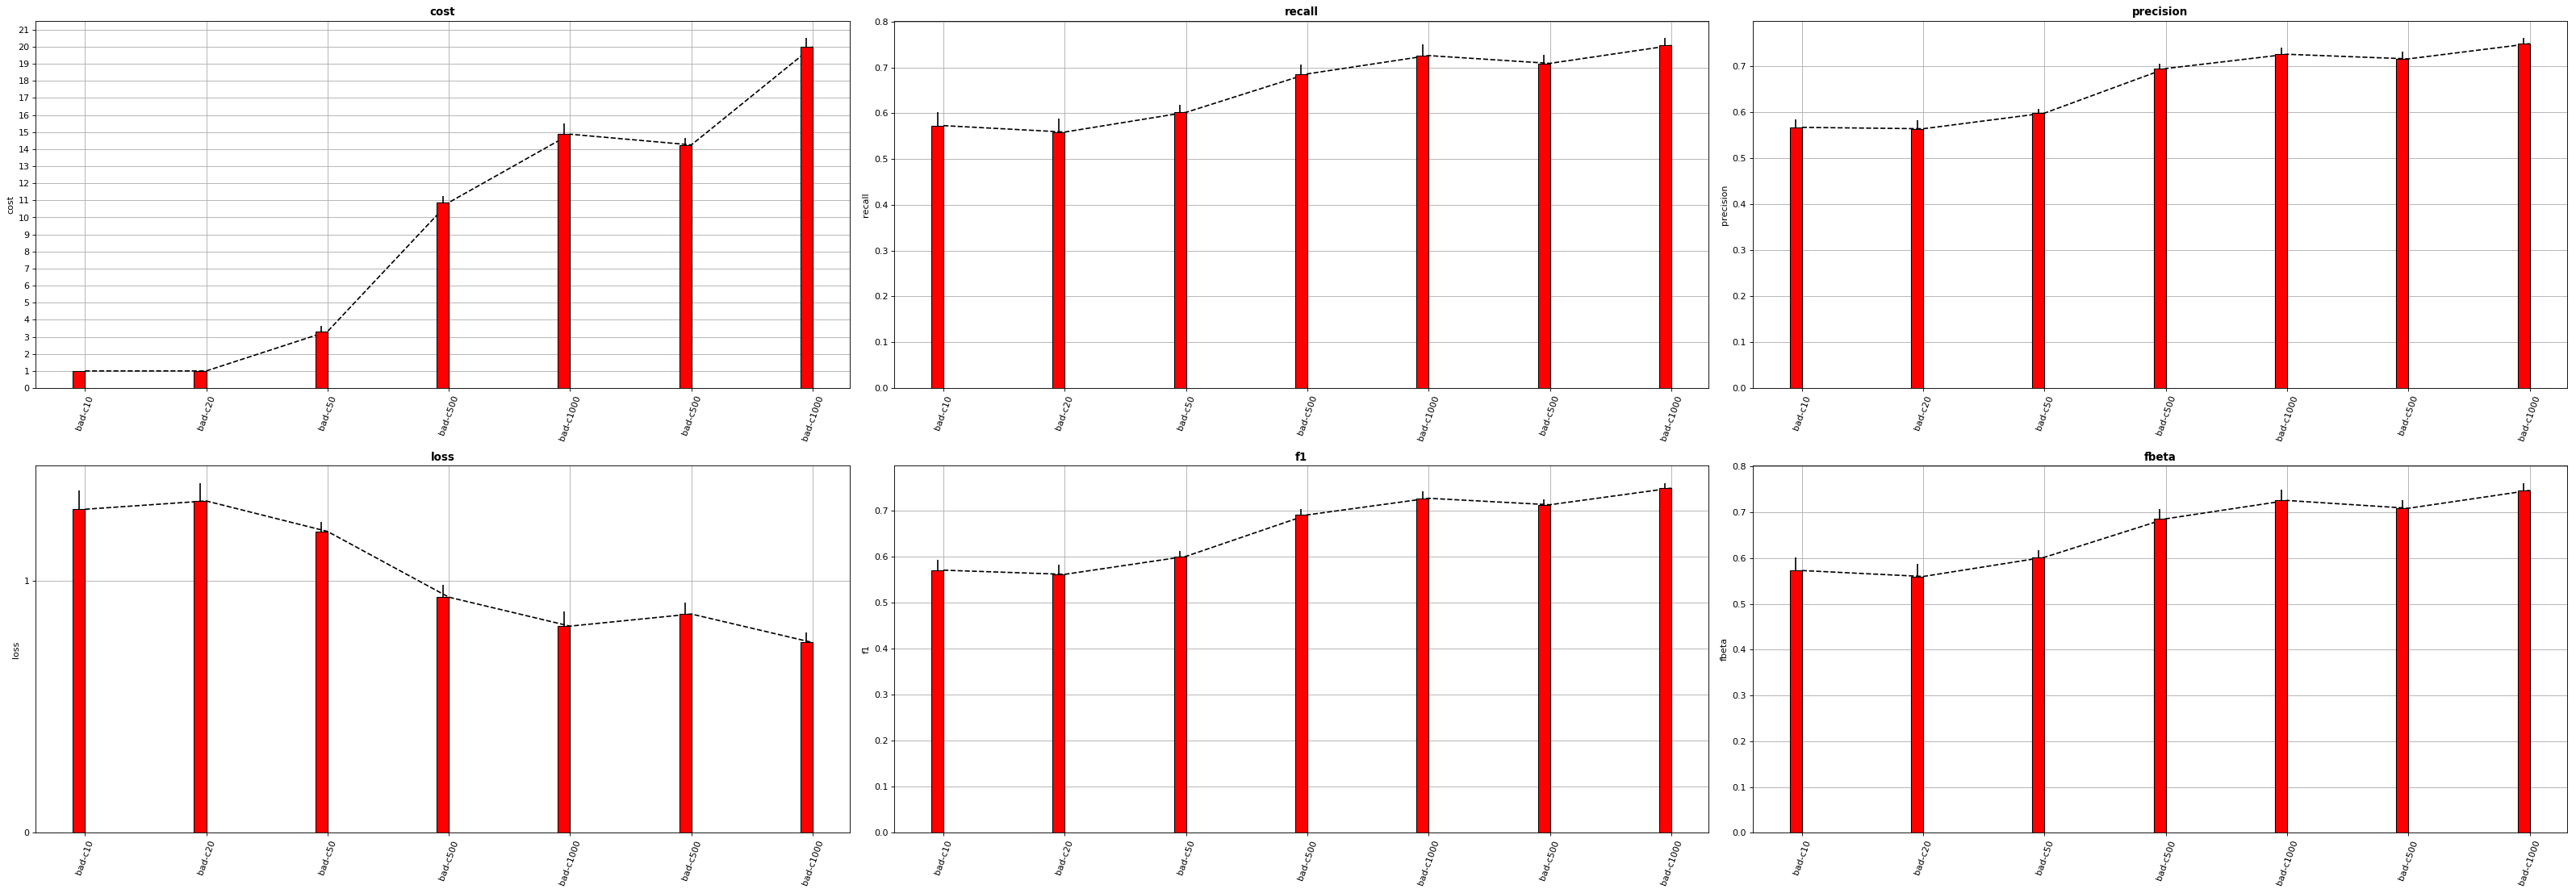

In [197]:
from IPython.core import display as ICD

data = pd.read_csv('/Users/pmaglione/Repos/adaptive-pomdp-solutions/dai_pomdp/results/pomdp_results.csv')
elems = data[data.name.str.startswith('bad')]

columns = ['cost', 'recall', 'precision', 'loss', 'f1', 'fbeta']

print(elems[['name', 'estimate_after']+columns])

plot_elems(elems, columns)

## 5. Workers error rate with a confusion matrix
- a worker error rate for possitive label class
- a higher worker error rate for negative label class



POMDP definition: 
 - States: 23
 
 Transitions: 
 - $T(S_i, Action=RequestVote, S_i) = 1$
 - $T(S_i, Action=SubmitTrue, S_{terminal}) = 1$
 - $T(S_i, Action=SubmitFalse, S_{terminal}) = 1$
 
 Observations probabilities:
 - $O(S_i, RequestVote, CorrectAnswer) = Acc$
 - $O(S_i, RequestVote, IncorrectAnswer) = 1 - Acc$
 
 Worker Accuracy Formula:
 - $Acc(d, \gamma) = \frac{1}{2} (1 + (1 - d)^{\gamma}) $
 
 Rewards:
 - Request vote: -1
 - Correct answer: 0
 - Wrong answer: {-10, -500, -1000, -5000, -10000, -15000}

Workers:
 - Amount: 100

Confusion Matrix:
 - Exclusion Error: $\gamma \sim Normal(1, 0.2)$
 - Inclusion Error: $\gamma \sim Normal(2, 0.2)$ 

## 6. Dont update belief immediately using average error rate, first compute each worker error rate
- Using worker error rate with distribution Normal(1, 0.2)
- Change logic to the following procedure, for each item $i \in I$, and a set of workers $W$ :
    1. Request vote for an item i
    2. Collect a worker vote over item i
    3. Estimate worker error rate and item true label using EM
    4. Update belief state over item i


Estimate after 2 votes
         name  estimate_after    cost  recall  precision   loss     f1  fbeta
0    base-c10           False   1.000   0.762      0.757  0.719  0.759  0.761
1    base-c20           False   1.000   0.751      0.757  0.743  0.754  0.751
2    base-c50           False   1.000   0.247      0.248  2.258  0.247  0.247
3   base-c500           False   7.925   0.985      0.985  0.044  0.985  0.985
4  base-c1000           False  10.286   0.995      0.993  0.015  0.994  0.995
5    base-c10            True   1.000   0.741      0.751  0.770  0.746  0.741
6    base-c20            True   1.000   0.760      0.758  0.721  0.759  0.760
7    base-c50            True   2.950   0.892      0.893  0.324  0.892  0.892
8   base-c500            True   9.613   0.995      0.994  0.017  0.994  0.995
9  base-c1000            True  12.224   0.998      0.999  0.005  0.999  0.998


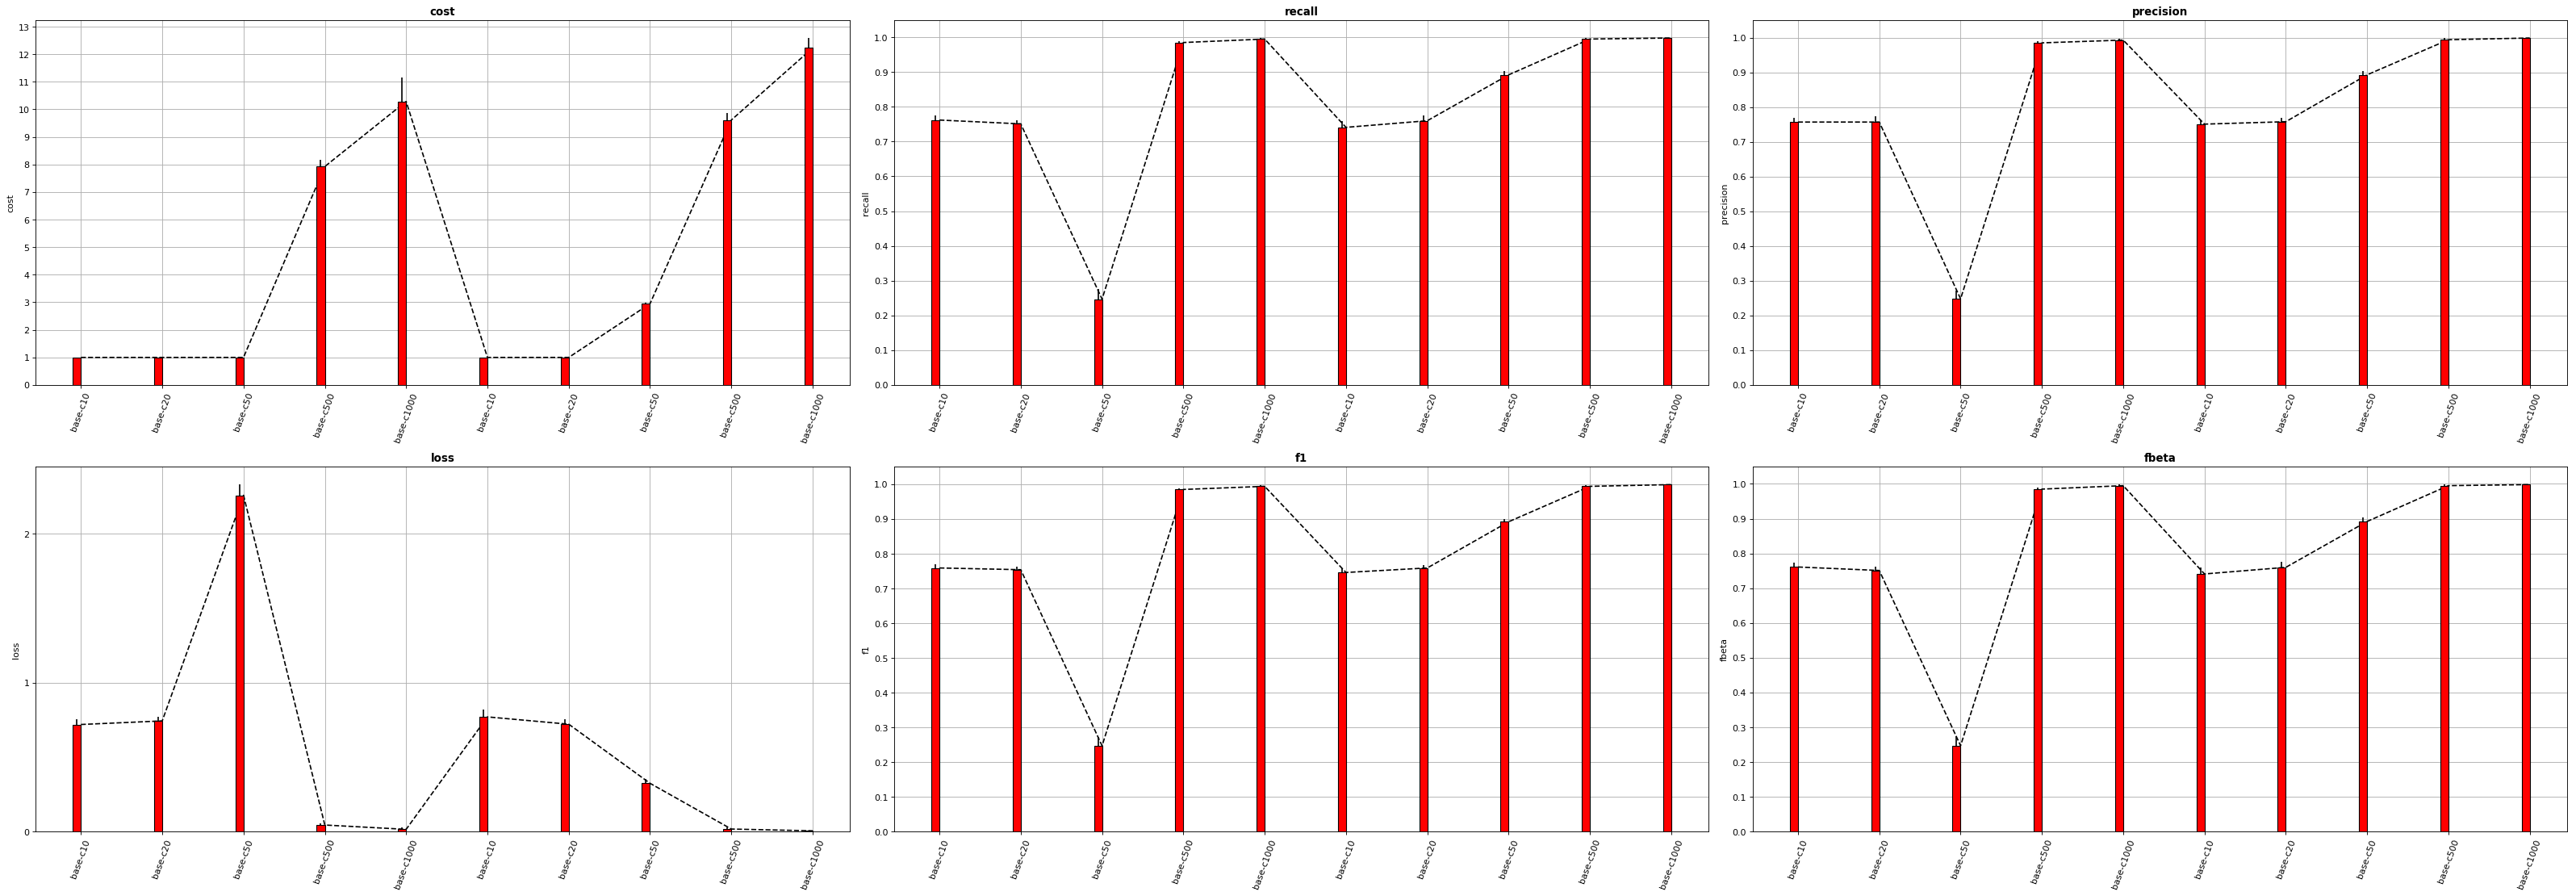

In [198]:
from IPython.core import display as ICD

print("Estimate after 2 votes")
data = pd.read_csv('/Users/pmaglione/Repos/adaptive-pomdp-solutions/dai_pomdp/results/pomdp_results.csv')
elems = data[data.name.str.startswith('base-')]

columns = ['cost', 'recall', 'precision', 'loss', 'f1', 'fbeta']

print(elems[['name', 'estimate_after']+columns])

plot_elems(elems, columns)

## 7. Try with different dataset balances to have an insight about next items belief state
- think in if we see a big % of items classified in a class and a new item arrives, the prob distribution over states should not be equally likely between all states